Q1  Q2  L1  L2  Throughput  Turnaround  Waiting  Response
 5  10  20  20  0.013       598.5       29.2    0.7
 5  10  20  30  0.010       570.1       35.0    0.0
 5  10  20  40  0.010       530.3       45.0    0.0
 5  10  30  20  0.010       536.8       35.0    0.0
 5  10  30  30  0.010       480.8       45.0    0.0
 5  10  30  40  0.011       597.9       56.1    0.2
 5  10  40  20  0.012       462.5       46.1    0.5
 5  10  40  30  0.010       499.8       55.0    0.0
 5  10  40  40  0.011       506.7       64.2    0.5
 5  16  20  20  0.012       386.8       24.1    0.5
 5  16  20  30  0.013       432.5       30.9    0.7
 5  16  20  40  0.012       440.6       38.6    0.5
 5  16  30  20  0.010       475.0       29.0    0.0
 5  16  30  30  0.010       478.0       39.0    0.0
 5  16  30  40  0.010       478.3       49.0    0.0
 5  16  40  20  0.010       669.6       39.0    0.0
 5  16  40  30  0.010       615.1       49.0    0.0
 5  16  40  40  0.010       573.0       59.0    0.0
 5  20

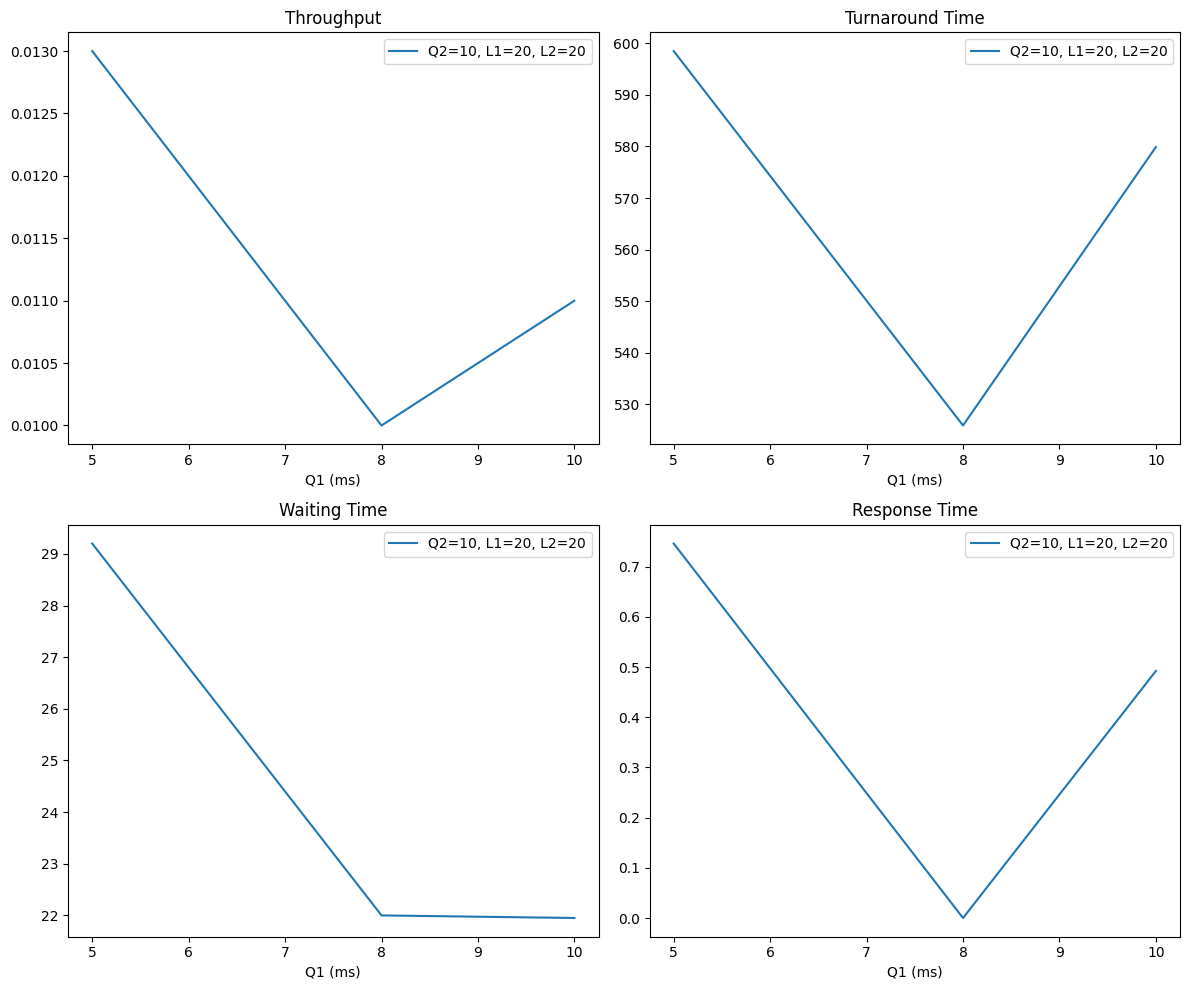

In [7]:
import random
import heapq
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

class Process:
    def __init__(self, pid, arrival_time, burst_time):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.remaining_time = burst_time
        self.start_time = None
        self.completion_time = None
        self.waiting_time = 0
        self.response_time = None
        self.queue_level = 0

class MLFQSimulator:
    def __init__(self, Q1, Q2, L1, L2, total_time=100):
        self.Q1 = Q1
        self.Q2 = Q2
        self.L1 = L1
        self.L2 = L2
        self.total_time = total_time
        self.queues = [deque(), deque(), deque()]  # Q0, Q1, Q2
        self.time = 0
        self.event_queue = []
        self.cpu_free = True
        self.time_spent = [0, 0, 0]  # Time spent in Q0, Q1, Q2
        self.current_process = None

    def simulate(self, processes):
        # Initialize event queue with arrivals
        for p in processes:
            heapq.heappush(self.event_queue, (p.arrival_time, 'arrival', p))

        while self.event_queue and self.time < self.total_time:
            time, event_type, process = heapq.heappop(self.event_queue)
            self.time = time

            if event_type == 'arrival':
                self.queues[0].append(process)
                if self.cpu_free:
                    self.schedule()
            elif event_type == 'quantum_expire' or event_type == 'complete':
                if event_type == 'complete':
                    process.completion_time = self.time
                elif process.remaining_time > 0:
                    process.queue_level += 1
                    if process.queue_level < 3:
                        self.queues[process.queue_level].append(process)
                self.cpu_free = True
                self.current_process = None
                self.schedule()

    def schedule(self):
        if not self.cpu_free:
            return

        # Determine which queue to serve based on time allocations
        if self.time_spent[0] < self.L1 and self.queues[0]:
            queue_idx = 0
            quantum = self.Q1
        elif self.time_spent[1] < self.L2 and self.queues[1]:
            queue_idx = 1
            quantum = self.Q2
        elif self.queues[2]:
            queue_idx = 2
            quantum = float('inf')  # FCFS
        else:
            return

        if self.queues[queue_idx]:
            self.cpu_free = False
            process = self.queues[queue_idx].popleft()
            self.current_process = process

            if process.start_time is None:
                process.start_time = self.time
                process.response_time = self.time - process.arrival_time

            # Calculate execution time
            exec_time = min(quantum, process.remaining_time)
            if queue_idx < 2:  # RR queues
                if self.time_spent[queue_idx] + exec_time > [self.L1, self.L2][queue_idx]:
                    exec_time = [self.L1, self.L2][queue_idx] - self.time_spent[queue_idx]

            process.remaining_time -= exec_time
            self.time_spent[queue_idx] += exec_time

            # Update waiting time for other processes
            for q in self.queues:
                for p in q:
                    if p != process and p.arrival_time <= self.time:
                        p.waiting_time += exec_time

            next_time = self.time + exec_time
            if process.remaining_time <= 0:
                heapq.heappush(self.event_queue, (next_time, 'complete', process))
            else:
                heapq.heappush(self.event_queue, (next_time, 'quantum_expire', process))

    def calculate_metrics(self, processes):
        completed = [p for p in processes if p.completion_time is not None]
        if not completed:
            return 0, 0, 0, 0
        throughput = len(completed) / self.total_time
        turnaround = sum(p.completion_time - p.arrival_time for p in completed) / len(completed)
        waiting = sum(p.waiting_time for p in completed) / len(completed)
        response = sum(p.response_time for p in completed) / len(completed)
        return throughput, turnaround, waiting, response

def run_simulations(N, M, Q1_vals, Q2_vals, L1_vals, L2_vals, num_runs=100):
    results = {}
    for Q1 in Q1_vals:
        for Q2 in Q2_vals:
            for L1 in L1_vals:
                for L2 in L2_vals:
                    if L1 + L2 >= 100:
                        continue
                    key = (Q1, Q2, L1, L2)
                    throughput_list, turnaround_list, waiting_list, response_list = [], [], [], []

                    for _ in range(num_runs):
                        processes = [Process(i, random.uniform(0, M), random.randint(10, 1000))
                                   for i in range(N)]
                        simulator = MLFQSimulator(Q1, Q2, L1, L2)
                        simulator.simulate(processes)
                        metrics = simulator.calculate_metrics(processes)
                        throughput_list.append(metrics[0])
                        turnaround_list.append(metrics[1])
                        waiting_list.append(metrics[2])
                        response_list.append(metrics[3])

                    results[key] = (
                        np.mean(throughput_list),
                        np.mean(turnaround_list),
                        np.mean(waiting_list),
                        np.mean(response_list)
                    )
    return results

def plot_results(results):
    Q1_vals = sorted(set(k[0] for k in results.keys()))
    Q2_vals = sorted(set(k[1] for k in results.keys()))
    L1_vals = sorted(set(k[2] for k in results.keys()))
    L2_vals = sorted(set(k[3] for k in results.keys()))

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    metrics = ['Throughput', 'Turnaround Time', 'Waiting Time', 'Response Time']

    for i, (ax, metric) in enumerate(zip(axs.flat, metrics)):
        data = np.array([[results.get((q1, Q2_vals[0], L1_vals[0], L2_vals[0]), (0, 0, 0, 0))[i]
                          for q1 in Q1_vals]])
        ax.plot(Q1_vals, data[0], label=f'Q2={Q2_vals[0]}, L1={L1_vals[0]}, L2={L2_vals[0]}')
        ax.set_title(metric)
        ax.set_xlabel('Q1 (ms)')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage
N, M = 1000, 100
Q1_vals = [5, 8, 10]
Q2_vals = [10, 16, 20]
L1_vals = [20, 30, 40]
L2_vals = [20, 30, 40]
results = run_simulations(N, M, Q1_vals, Q2_vals, L1_vals, L2_vals, num_runs=10)

# Print results in a table
print("Q1  Q2  L1  L2  Throughput  Turnaround  Waiting  Response")
for (Q1, Q2, L1, L2), (t, ta, w, r) in results.items():
    print(f"{Q1:2d}  {Q2:2d}  {L1:2d}  {L2:2d}  {t:.3f}       {ta:.1f}       {w:.1f}    {r:.1f}")

# Plot results
plot_results(results)